In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

In [2]:
def draw_window(ax, xmin, ymin, xmax, ymax):
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(rect)

In [3]:
def point_clipping(xmin, ymin, xmax, ymax):
    fig, ax = plt.subplots()
    draw_window(ax, xmin, ymin, xmax, ymax)

    n = int(input("Enter number of points: "))
    points = []

    for i in range(n):
        x = float(input(f"Enter x coordinate of point {i+1}: "))
        y = float(input(f"Enter y coordinate of point {i+1}: "))
        points.append((x, y))

    for x, y in points:
        if xmin <= x <= xmax and ymin <= y <= ymax:
            ax.plot(x, y, 'go')  # Inside - green
        else:
            ax.plot(x, y, 'ro')  # Outside - red

    ax.set_title('Point Clipping')
    ax.set_xlim(0, 400)
    ax.set_ylim(0, 400)
    plt.gca().invert_yaxis()
    plt.grid()
    plt.show()

In [4]:
# Define region codes
INSIDE, LEFT, RIGHT, BOTTOM, TOP = 0, 1, 2, 4, 8

def compute_code(x, y, xmin, ymin, xmax, ymax):
    code = INSIDE
    if x < xmin: code |= LEFT
    elif x > xmax: code |= RIGHT
    if y < ymin: code |= BOTTOM
    elif y > ymax: code |= TOP
    return code

In [5]:
def cohen_sutherland_clip(x1, y1, x2, y2, xmin, ymin, xmax, ymax):
    code1 = compute_code(x1, y1, xmin, ymin, xmax, ymax)
    code2 = compute_code(x2, y2, xmin, ymin, xmax, ymax)
    accept = False

    while True:
        if not (code1 | code2):
            accept = True
            break
        elif code1 & code2:
            break
        else:
            x, y = 0.0, 0.0
            out_code = code1 if code1 else code2

            if out_code & TOP:
                x = x1 + (x2 - x1) * (ymax - y1) / (y2 - y1)
                y = ymax
            elif out_code & BOTTOM:
                x = x1 + (x2 - x1) * (ymin - y1) / (y2 - y1)
                y = ymin
            elif out_code & RIGHT:
                y = y1 + (y2 - y1) * (xmax - x1) / (x2 - x1)
                x = xmax
            elif out_code & LEFT:
                y = y1 + (y2 - y1) * (xmin - x1) / (x2 - x1)
                x = xmin

            if out_code == code1:
                x1, y1 = x, y
                code1 = compute_code(x1, y1, xmin, ymin, xmax, ymax)
            else:
                x2, y2 = x, y
                code2 = compute_code(x2, y2, xmin, ymin, xmax, ymax)

    if accept:
        return (x1, y1, x2, y2)
    else:
        return None

In [6]:
def line_clipping(xmin, ymin, xmax, ymax):

    fig, ax = plt.subplots()
    draw_window(ax, xmin, ymin, xmax, ymax)

    n = int(input("Enter number of lines: "))
    lines = []
    for i in range(n):
        print(f"Line {i+1}:")
        x1 = float(input("  Enter x1: "))
        y1 = float(input("  Enter y1: "))
        x2 = float(input("  Enter x2: "))
        y2 = float(input("  Enter y2: "))
        lines.append(((x1, y1), (x2, y2)))

    for (x1, y1), (x2, y2) in lines:
        clipped = cohen_sutherland_clip(x1, y1, x2, y2, xmin, ymin, xmax, ymax)
        ax.plot([x1, x2], [y1, y2], 'r--')  # original line in red dashed
        if clipped:
            cx1, cy1, cx2, cy2 = clipped
            ax.plot([cx1, cx2], [cy1, cy2], 'g-')  # clipped line in green

    ax.set_title('Line Clipping - Cohen Sutherland')
    ax.set_xlim(0, 400)
    ax.set_ylim(0, 400)
    plt.gca().invert_yaxis()
    plt.grid()
    plt.show()

In [7]:
def clip_polygon(subjectPolygon, clipEdge, xmin, ymin, xmax, ymax):
    def inside(p):
        x, y = p
        if clipEdge == 'LEFT':
            return x >= xmin
        elif clipEdge == 'RIGHT':
            return x <= xmax
        elif clipEdge == 'BOTTOM':
            return y >= ymin
        elif clipEdge == 'TOP':
            return y <= ymax

    def compute_intersection(p1, p2):
        x1, y1 = p1
        x2, y2 = p2
        if clipEdge == 'LEFT':
            x, y = xmin, y1 + (y2 - y1) * (xmin - x1) / (x2 - x1)
        elif clipEdge == 'RIGHT':
            x, y = xmax, y1 + (y2 - y1) * (xmax - x1) / (x2 - x1)
        elif clipEdge == 'BOTTOM':
            y, x = ymin, x1 + (x2 - x1) * (ymin - y1) / (y2 - y1)
        elif clipEdge == 'TOP':
            y, x = ymax, x1 + (x2 - x1) * (ymax - y1) / (y2 - y1)
        return (x, y)

    outputList = []
    inputList = subjectPolygon
    s = inputList[-1]

    for e in inputList:
        if inside(e):
            if not inside(s):
                outputList.append(compute_intersection(s, e))
            outputList.append(e)
        elif inside(s):
            outputList.append(compute_intersection(s, e))
        s = e

    return outputList

In [8]:
def polygon_clipping(xmin, ymin, xmax, ymax):
    fig, ax = plt.subplots()
    draw_window(ax, xmin, ymin, xmax, ymax)

    n = int(input("Enter number of vertices for the polygon: "))
    subjectPolygon = []

    for i in range(n):
        x = float(input(f"Enter x-coordinate of vertex {i+1}: "))
        y = float(input(f"Enter y-coordinate of vertex {i+1}: "))
        subjectPolygon.append((x, y))

    clipEdges = ['LEFT', 'RIGHT', 'BOTTOM', 'TOP']
    poly = subjectPolygon
    for edge in clipEdges:
        poly = clip_polygon(poly, edge, xmin, ymin, xmax, ymax)

    x, y = zip(*subjectPolygon)
    ax.plot(x + (x[0],), y + (y[0],), 'r--', label='Original Polygon')

    if poly:
        cx, cy = zip(*poly)
        ax.plot(cx + (cx[0],), cy + (cy[0],), 'g-', label='Clipped Polygon')

    ax.set_title('Polygon Clipping - Sutherland Hodgeman')
    ax.set_xlim(0, 400)
    ax.set_ylim(0, 400)
    plt.gca().invert_yaxis()
    plt.grid()
    plt.legend()
    plt.show()

In [9]:
def menu(xmin, ymin, xmax, ymax):
    while True:
        print("\nMenu:")
        print("1. Point Clipping")
        print("2. Line Clipping")
        print("3. Polygon Clipping")
        print("4. Exit")

        choice = input("Enter choice: ")
        if choice == '1':
            point_clipping(xmin, ymin, xmax, ymax)
        elif choice == '2':
            line_clipping(xmin, ymin, xmax, ymax)
        elif choice == '3':
            polygon_clipping(xmin, ymin, xmax, ymax)
        elif choice == '4':
            break
        else:
            print("Invalid choice.")

In [10]:
# xmin, ymin = 100, 100
# xmax, ymax = 300, 300

# points = [(150, 150), (90, 90), (310, 250), (200, 310)]
# lines = [((50, 50), (350, 350)), ((120, 120), (180, 280)), ((50, 200), (200, 50))]
# subjectPolygon = [(50, 150), (200, 50), (350, 150), (350, 300), (250, 350), (100, 300)]



Menu:
1. Point Clipping
2. Line Clipping
3. Polygon Clipping
4. Exit


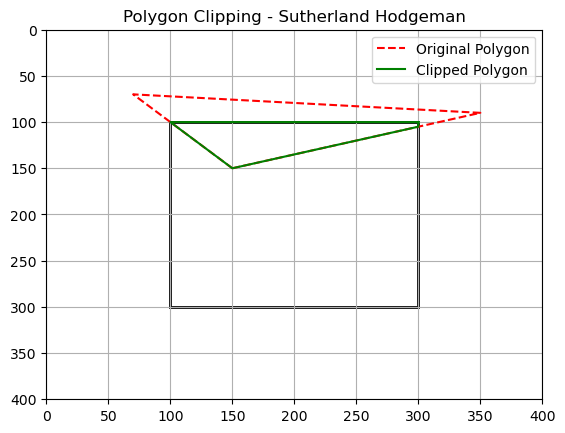


Menu:
1. Point Clipping
2. Line Clipping
3. Polygon Clipping
4. Exit


In [11]:
if __name__ == "__main__":
    xmin = float(input("Enter xmin of clipping window: "))
    ymin = float(input("Enter ymin of clipping window: "))
    xmax = float(input("Enter xmax of clipping window: "))
    ymax = float(input("Enter ymax of clipping window: "))
    menu(xmin, ymin, xmax, ymax)